# Imports:

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from importlib import reload 
from art.attacks.evasion import AutoProjectedGradientDescent,ProjectedGradientDescent,AdversarialPatch,BasicIterativeMethod,CarliniL2Method,CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from joblib import dump, load
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from torch.utils.data import TensorDataset, DataLoader,SubsetRandomSampler
from torchvision import transforms, datasets
from tqdm import tqdm  
import os
import cv2
from MPD_Thres import MPD_Threshold_Calculator
import AEFinder
import AE_Generator
import MPD
import MPD_Thres
reload(AEFinder)
reload(AE_Generator)
reload(MPD)
reload(MPD_Thres)
from AE_Generator import AEGenerator
from MPD import MPD_Evaluator
from MPD_Thres import MPD_Threshold_Calculator


# Create the Model Architechture:


In [2]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, p=0.5):
        super(TrafficSignClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 43)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool2(x)
        x = self.dropout(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool3(x)
        x = self.dropout(x)
        
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# DataLoaders:

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(),])

In [4]:
train_dataset = datasets.ImageFolder(root='D:/Code/Lab105_Personal/Atharva_MPD/Datasets/GTSRB/train_image', transform=transform)
print(f"Length of training dataset: {len(train_dataset)}")
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Length of training dataset: 96750


In [5]:
test_dataset = datasets.ImageFolder(root='D:/Code/Lab105_Personal/Atharva_MPD/Datasets/GTSRB/test_image', transform=transform)
print(f"Length of test dataset: {len(test_dataset)}")
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Length of test dataset: 32250


# Load Test Data:

In [3]:
# Load x_test and y_test
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [4]:
# Print the shapes
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_test: (32250, 3, 32, 32)
Shape of y_test: (32250,)


# Load Base GTSRB Model:

In [5]:
base_model =TrafficSignClassifier()
# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
base_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

cuda


In [6]:
# Define the path to the saved model file
model_path = "GTSRB_Clean/GTSRB_Clean_Model.pth"

# Load only the model's parameters
state_dict = torch.load(model_path, map_location=torch.device('cuda'))

# Load the parameters into the model
base_model.load_state_dict(state_dict)


<All keys matched successfully>

# Create ART PyTorch Classifier:

In [7]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=base_model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=43,
    # device_type='cuda',
    clip_values=(0.0,1.0)
    
)

In [8]:
#Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
predictions=np.argmax(predictions, axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Accuracy on the test set: {accuracy*100:.2f}%")

Accuracy on the test set: 96.05%


In [9]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
clear_gpu_memory()

# Find Best Parameters:

In [7]:
#You can use the AEFinder.py code and find the best parameters for each attack
#Examples:
# bim=AEFinder.AE_Finder(classifier,'bim',x_test,y_test)
# bim.finder()

############ BIM PARAMETERS ############

Best eps: 0.05, Best eps_step: 0.01, Best max_iter: 30, Maximum successful attacks: 100

############ PGD PARAMETERS ############

Best eps: 0.05, Best eps_step: 0.02, Best max_iter: 40, Maximum successful attacks: 100

############ APGD PARAMETERS ############

Best eps: 0.06999999999999999, Best eps_step: 0.05, Best max_iter: 90, Maximum successful attacks: 100

############ CW PARAMETERS ############

Best learning_rate: 0.01, Best max_iter: 40, Maximum successful attacks: 100

# Generate AEs:

In [8]:
#You can generate the samples using the AEGenerator.py:
#Example:

# cw_attack=AEGenerator(classifier, 'cwlinf', x_test, y_test,learning_rate=0.01,max_iter=40)
#dump(cw_attack,'AttackSamples/cw_attack.joblib')


## BIM:

In [10]:
#Loading the samples 
bim_attack=load('AttackSamples/bim_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(bim_attack.attack_name.upper(), bim_attack.acc_adv * 100))
print()
print(f"The number of {bim_attack.attack_name.upper()} samples that successfully evaded the model are - {len(bim_attack.false_indices)}")

Accuracy on BIM adversarial test examples: 3.5348837209302326%

The number of BIM samples that successfully evaded the model are - 31110


## PGD:

In [11]:
#Loading the samples 
pgd_attack=load('AttackSamples/pgd_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(pgd_attack.attack_name.upper(), pgd_attack.acc_adv * 100))
print()
print(f"The number of {bim_attack.attack_name.upper()} samples that successfully evaded the model are - {len(pgd_attack.false_indices)}")

Accuracy on PGDLINF adversarial test examples: 3.336434108527132%

The number of BIM samples that successfully evaded the model are - 31174


## APGD:

In [12]:
#Loading the samples 
apgd_attack=load('AttackSamples/apgd_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(apgd_attack.attack_name.upper(), apgd_attack.acc_adv * 100))
print()
print(f"The number of {apgd_attack.attack_name.upper()} samples that successfully evaded the model are - {len(apgd_attack.false_indices)}")

Accuracy on APGDLINF adversarial test examples: 1.1534883720930234%

The number of APGDLINF samples that successfully evaded the model are - 31878


## CW:

In [13]:
#Loading the samples 
cw_attack=load('AttackSamples/cw_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(cw_attack.attack_name.upper(), cw_attack.acc_adv * 100))
print()
print(f"The number of {cw_attack.attack_name.upper()} samples that successfully evaded the model are - {len(cw_attack.false_indices)}")

Accuracy on CWLINF adversarial test examples: 2.6232558139534885%

The number of CWLINF samples that successfully evaded the model are - 31404


## Adversarial Patch:

In [14]:
# attack= AdversarialPatchPyTorch(classifier,
#                                 learning_rate=0.01,
#                             patch_shape = (3, 32, 32),
#                             targeted=False,
#                             verbose = True,
#                             batch_size= 1000,
# )

In [15]:
patch=load('AttackSample/patch_new.joblib')

### Patch:

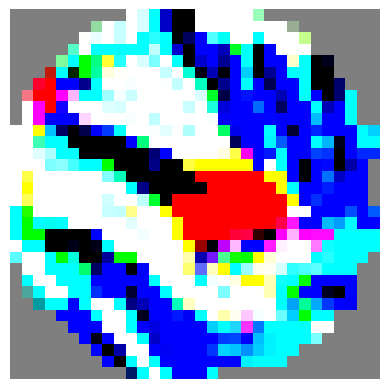

In [16]:
plt.imshow(np.transpose(patch[0], (1, 2, 0)))
plt.axis('off')
plt.show()

In [17]:
# x_test_ap=attack.apply_patch(x_test,scale=0.5,patch_external=patch[0])

In [18]:
x_test_ap=load('AttackSample/AP_AES_10k.joblib')

In [19]:
# Evaluate the ART classifier on the adversarial test examples
ap_adv_preds = classifier.predict(x_test_ap)

# Getting the individual predictions and their indices
ap_ind_pred = np.argmax(ap_adv_preds, axis=1) == y_test
ap_false_indices = np.where(~ap_ind_pred)[0].tolist()

# Calculating the accuracy
ap_acc_adv = np.sum(np.argmax(ap_adv_preds, axis=1)==y_test) / len(y_test)
print("Accuracy on {} adversarial test examples: {}%".format('Adversarial Patch', ap_acc_adv * 100))
print()
print(f"The number of Adversarial Patch samples that successfully evaded the model are - {len(ap_false_indices)}")
clear_gpu_memory()

Accuracy on Adversarial Patch adversarial test examples: 45.627906976744185%

The number of Adversarial Patch samples that successfully evaded the model are - 17535


# MPD:

## Load the Ensemble:

In [20]:
# Define the directory where the models are saved
save_dir = "GTSRB_Ensemble/"

# List to store loaded model
ensemble_models = []

# Loop through each saved model file
for i in range(100):
    # Define the path to the saved model file
    model_path = os.path.join(save_dir, f"model_{i+1}.pth")
    # Instantiate the model architecture
    model = TrafficSignClassifier()
    # Load the saved model state dictionary
    model.load_state_dict(torch.load(model_path))
    # Append the loaded model to the list
    ensemble_models.append(model)

## Create MPD Detector:

In [21]:
mpd_detector=MPD_Evaluator(ensemble_models, 43, 100)

## Getting the AEs:

In [22]:
bim_samples=bim_attack.x_test_adv
pgdlinf_samples=pgd_attack.x_test_adv
apgdlinf_samples=apgd_attack.x_test_adv
cwlinf_samples=cw_attack.x_test_adv


In [23]:
print(f"Shape of Clean Samples - {x_test.shape}")
print(f"Shape of BIM Samples - {bim_samples.shape}")
print(f"Shape of PGD Samples - {pgdlinf_samples.shape}")
print(f"Shape of AutoPGD Samples - {apgdlinf_samples.shape}")
print(f"Shape of CW Samples - {cwlinf_samples.shape}")
print(f"Shape of AE Samples - {x_test_ap.shape}")

Shape of Clean Samples - (32250, 3, 32, 32)
Shape of BIM Samples - (32250, 3, 32, 32)
Shape of PGD Samples - (32250, 3, 32, 32)
Shape of AutoPGD Samples - (32250, 3, 32, 32)
Shape of CW Samples - (32250, 3, 32, 32)
Shape of AE Samples - (32250, 3, 32, 32)


In [24]:
def Test_Set(x_test,y_test):


    x_test_stratified, _, y_test_stratified, _ = train_test_split(x_test, y_test, test_size=0.689922, stratify=y_test, random_state=333)
    return x_test_stratified

In [25]:
x_test_clean=Test_Set(x_test,y_test)
x_test_bim=Test_Set(bim_samples,y_test)
x_test_pgdlinf=Test_Set(pgdlinf_samples,y_test)
x_test_apgdlinf=Test_Set(apgdlinf_samples,y_test)
x_test_cwlinf=Test_Set(cwlinf_samples,y_test)
ap_x_test=Test_Set(x_test_ap,y_test)

In [26]:
print(f"Shape of Clean Samples - {x_test_clean.shape}")
print(f"Shape of BIM Samples - {x_test_bim.shape}")
print(f"Shape of PGD Samples - {x_test_pgdlinf.shape}")
print(f"Shape of AutoPGD Samples - {x_test_apgdlinf.shape}")
print(f"Shape of CW Samples - {x_test_cwlinf.shape}")
print(f"Shape of AP Samples - {ap_x_test.shape}")

Shape of Clean Samples - (10000, 3, 32, 32)
Shape of BIM Samples - (10000, 3, 32, 32)
Shape of PGD Samples - (10000, 3, 32, 32)
Shape of AutoPGD Samples - (10000, 3, 32, 32)
Shape of CW Samples - (10000, 3, 32, 32)
Shape of AP Samples - (10000, 3, 32, 32)


## MPD Scores for Full Test Set:

In [27]:
mpd_scores_normal=mpd_detector.evaluate(x_test_clean)

In [28]:
clear_gpu_memory()

In [29]:
mpd_scores_bim=mpd_detector.evaluate(x_test_bim)

In [30]:
clear_gpu_memory()

In [31]:
mpd_scores_pgd=mpd_detector.evaluate(x_test_pgdlinf)

In [32]:
clear_gpu_memory()

In [33]:
mpd_scores_apgd=mpd_detector.evaluate(x_test_apgdlinf)

In [34]:
clear_gpu_memory()

In [35]:
mpd_scores_cw=mpd_detector.evaluate(x_test_cwlinf)

In [36]:
clear_gpu_memory()

In [37]:
mpd_scores_ap=mpd_detector.evaluate(ap_x_test)

In [38]:
clear_gpu_memory()

In [46]:
atks = {
    'clean':mpd_scores_normal,
    'bim': mpd_scores_bim,
    'pgd': mpd_scores_pgd,
    'autopgd': mpd_scores_apgd,
    'cw': mpd_scores_cw,
    'ap': mpd_scores_ap
}

In [47]:
max_mpd_scores = {}

def mpd_maxscores(atk_name, mpd_scores):
    max_value = round(mpd_scores.max(), 2)
    max_mpd_scores[atk_name] = max_value
    print(f"The max mpd score for {atk_name.upper()} = {max_value}")

In [48]:
for names in atks.keys():
    mpd_maxscores(names,atks[names])

The max mpd score for CLEAN = 0.87
The max mpd score for BIM = 0.9
The max mpd score for PGD = 0.89
The max mpd score for AUTOPGD = 0.92
The max mpd score for CW = 0.88
The max mpd score for AP = 0.93


In [49]:
def mpd_score_graph(atk_name,mpd_scores):
    if atk_name=='clean':
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title("MPD scores before attack")
        plt.ylim(0,7000)
    else:
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title(f"MPD scores after {atk_name.upper()} attack")
        plt.ylim(0,5500)

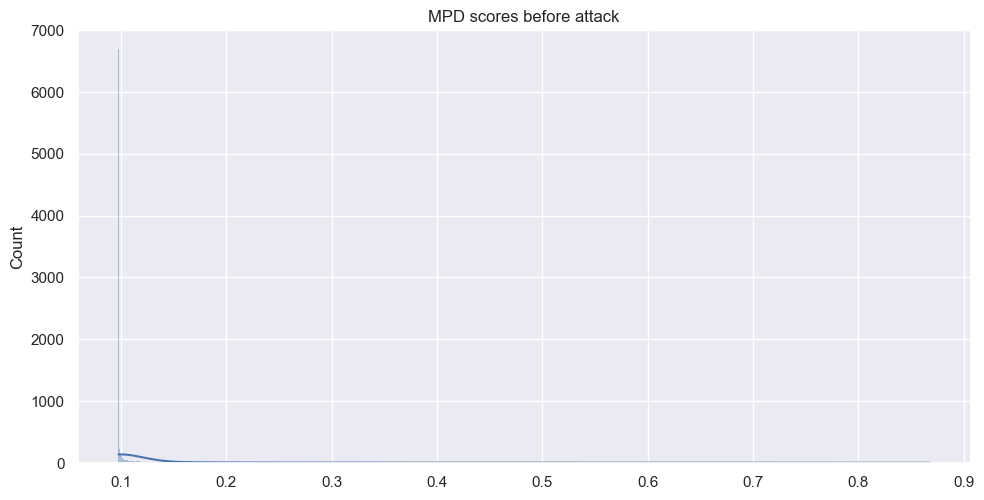

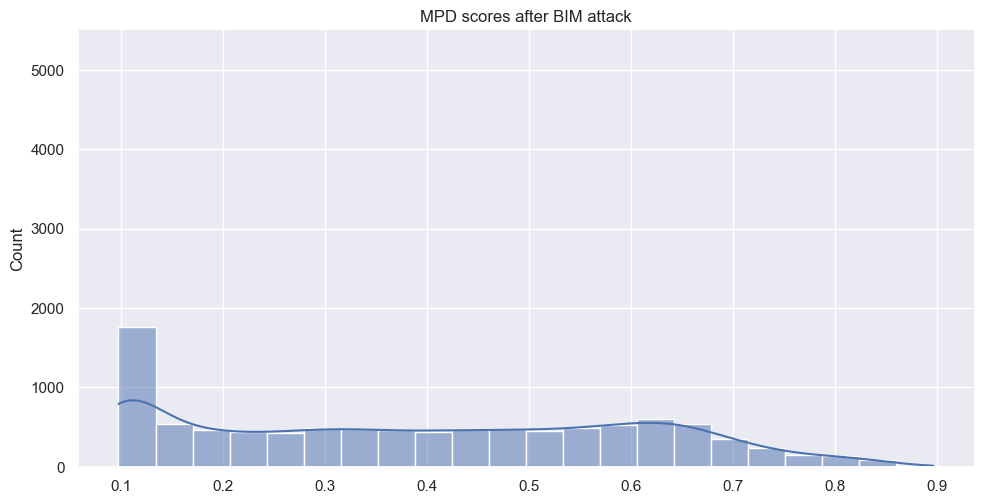

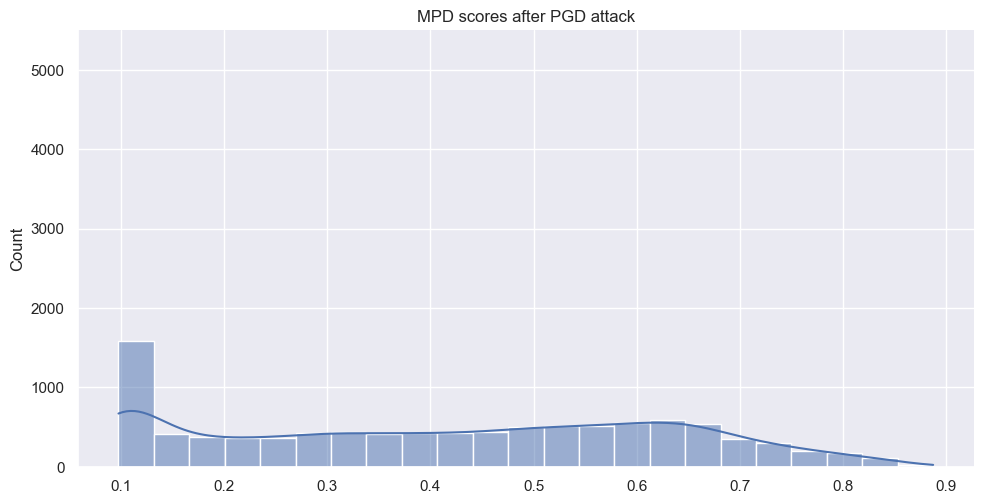

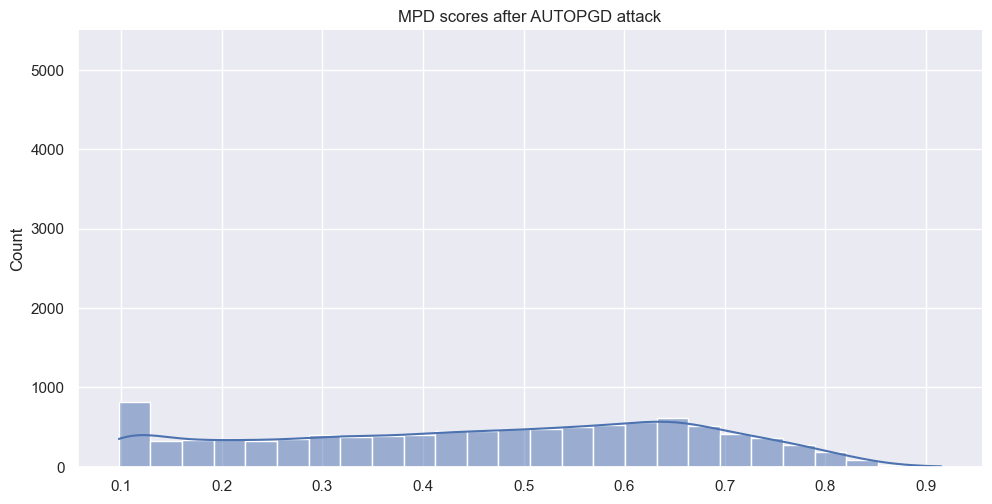

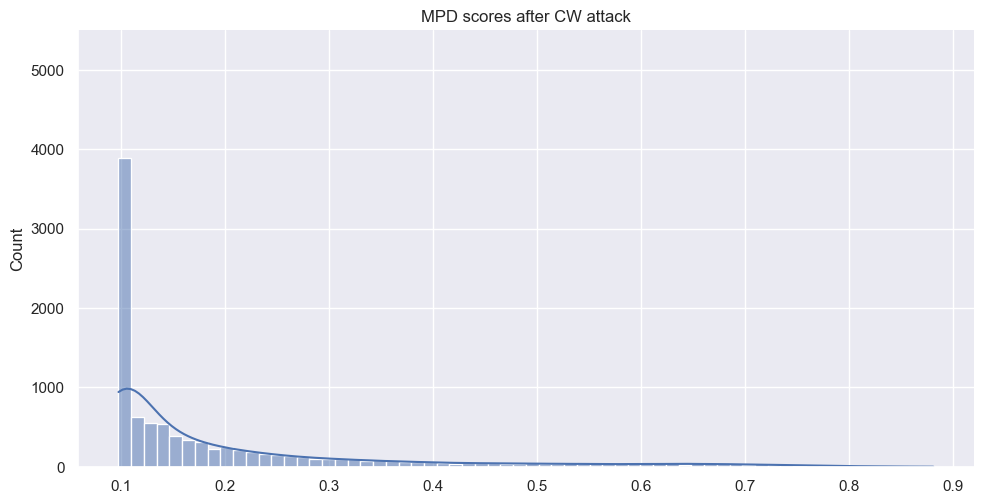

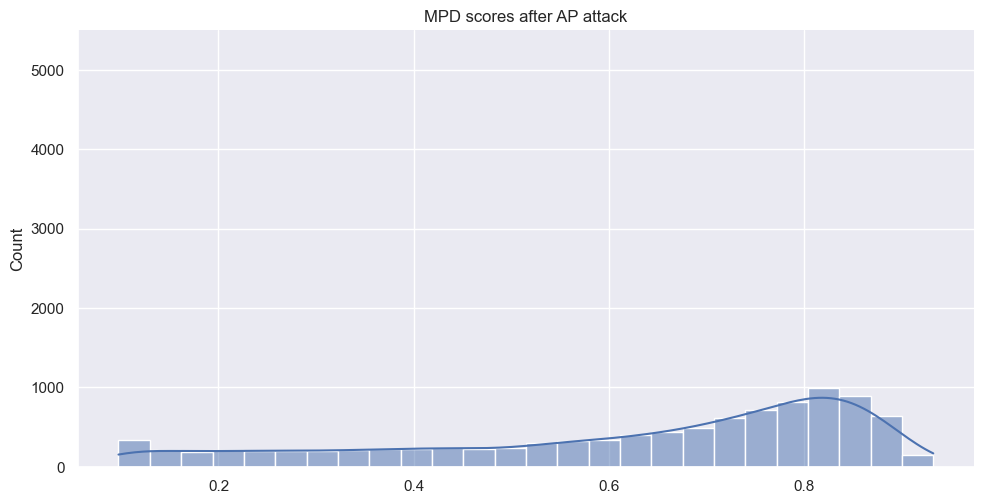

In [50]:
for names in atks.keys(): 
    mpd_score_graph(names,atks[names])

## Finding Common Samples for all attacks:

In [28]:
# Find common elements across all lists
common_indices = list(set(bim_attack.false_indices) & set(pgd_attack.false_indices) & set(apgd_attack.false_indices) & set(cw_attack.false_indices))
#print("Common Indices:", common_indices)
print("Common Samples found :", len(common_indices))

Common Samples found : 30650


In [52]:
common_samples_cln=x_test[common_indices]

In [53]:
common_samples_bim=bim_samples[common_indices]

In [54]:
common_samples_pgd=pgdlinf_samples[common_indices]

In [55]:
common_samples_apgd=apgdlinf_samples[common_indices]

In [56]:
common_samples_apgd=apgdlinf_samples[common_indices]

In [57]:
common_samples_cw=cwlinf_samples[common_indices]

In [58]:
working_samples_ap_clean=x_test[ap_false_indices]
working_samples_ap=x_test_ap[ap_false_indices]
ap_y_test=y_test[ap_false_indices]

In [59]:
#Function for class distribution
def class_dist(labels):
    # get unique class labels and their counts
    unique_classes, class_counts= np.unique(labels, return_counts=True)

    # Print the class distribution
    for label, count in zip(unique_classes, class_counts):
        print(f"Class {label}: {count} samples")

In [60]:
y_common_samples=y_test[common_indices]
class_dist(y_common_samples)

Class 0: 750 samples
Class 1: 717 samples
Class 2: 729 samples
Class 3: 703 samples
Class 4: 733 samples
Class 5: 716 samples
Class 6: 705 samples
Class 7: 738 samples
Class 8: 727 samples
Class 9: 746 samples
Class 10: 738 samples
Class 11: 745 samples
Class 12: 682 samples
Class 13: 739 samples
Class 14: 716 samples
Class 15: 647 samples
Class 16: 748 samples
Class 17: 424 samples
Class 18: 680 samples
Class 19: 745 samples
Class 20: 747 samples
Class 21: 608 samples
Class 22: 647 samples
Class 23: 723 samples
Class 24: 747 samples
Class 25: 691 samples
Class 26: 723 samples
Class 27: 750 samples
Class 28: 738 samples
Class 29: 748 samples
Class 30: 706 samples
Class 31: 747 samples
Class 32: 750 samples
Class 33: 729 samples
Class 34: 644 samples
Class 35: 730 samples
Class 36: 722 samples
Class 37: 750 samples
Class 38: 741 samples
Class 39: 716 samples
Class 40: 742 samples
Class 41: 728 samples
Class 42: 695 samples


## Creating Clean Samples Testbed:

In [61]:
x_test_stratified_clean, _, y_test_stratified_clean, _ = train_test_split(x_test, y_test, test_size=0.767441, stratify=y_test, random_state=333)

# Now, x_test_stratified and y_test_stratified contain 75% of the stratified test data
print("Shape of x_test_stratified:", x_test_stratified_clean.shape)
print("Shape of y_test_stratified:", y_test_stratified_clean.shape)

Shape of x_test_stratified: (7500, 3, 32, 32)
Shape of y_test_stratified: (7500,)


In [62]:
class_dist(y_test_stratified_clean)

Class 0: 175 samples
Class 1: 175 samples
Class 2: 175 samples
Class 3: 174 samples
Class 4: 175 samples
Class 5: 174 samples
Class 6: 175 samples
Class 7: 174 samples
Class 8: 174 samples
Class 9: 174 samples
Class 10: 175 samples
Class 11: 175 samples
Class 12: 174 samples
Class 13: 174 samples
Class 14: 175 samples
Class 15: 175 samples
Class 16: 175 samples
Class 17: 175 samples
Class 18: 175 samples
Class 19: 174 samples
Class 20: 174 samples
Class 21: 175 samples
Class 22: 174 samples
Class 23: 174 samples
Class 24: 175 samples
Class 25: 174 samples
Class 26: 174 samples
Class 27: 174 samples
Class 28: 174 samples
Class 29: 174 samples
Class 30: 175 samples
Class 31: 175 samples
Class 32: 174 samples
Class 33: 174 samples
Class 34: 175 samples
Class 35: 174 samples
Class 36: 174 samples
Class 37: 174 samples
Class 38: 175 samples
Class 39: 174 samples
Class 40: 174 samples
Class 41: 174 samples
Class 42: 174 samples


## Evaluating AEs:



Shape of x_test_stratified_bim: (2500, 3, 32, 32)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for BIM :
Class 0: 61 samples
Class 1: 59 samples
Class 2: 59 samples
Class 3: 57 samples
Class 4: 60 samples
Class 5: 58 samples
Class 6: 58 samples
Class 7: 60 samples
Class 8: 59 samples
Class 9: 61 samples
Class 10: 60 samples
Class 11: 61 samples
Class 12: 56 samples
Class 13: 60 samples
Class 14: 58 samples
Class 15: 53 samples
Class 16: 61 samples
Class 17: 35 samples
Class 18: 55 samples
Class 19: 61 samples
Class 20: 61 samples
Class 21: 50 samples
Class 22: 53 samples
Class 23: 59 samples
Class 24: 61 samples
Class 25: 56 samples
Class 26: 59 samples
Class 27: 61 samples
Class 28: 60 samples
Class 29: 61 samples
Class 30: 58 samples
Class 31: 61 samples
Class 32: 61 samples
Class 33: 59 samples
Class 34: 53 samples
Class 35: 60 samples
Class 36: 59 samples
Class 37: 61 samples
Class 38: 60 samples
Class 39: 58 samples
Class 40: 61 samples
Class 41: 59 samples
Class

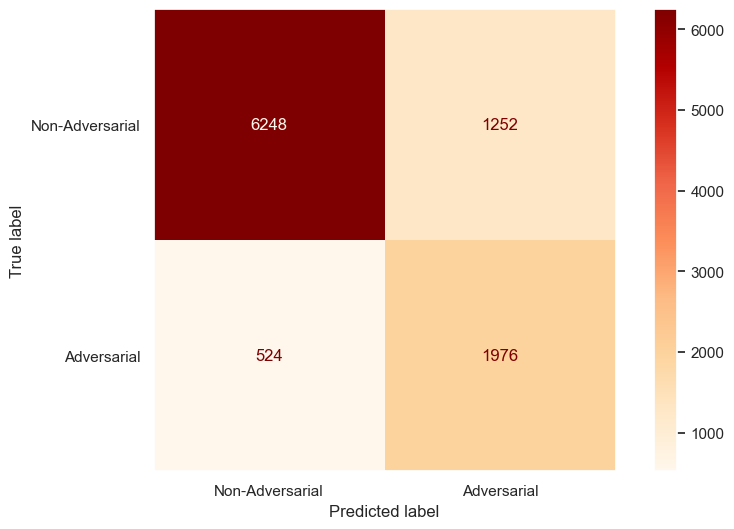

In [63]:
bim_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'bim',common_samples_cln,common_samples_bim,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 3, 32, 32)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for PGD :
Class 0: 61 samples
Class 1: 59 samples
Class 2: 59 samples
Class 3: 57 samples
Class 4: 60 samples
Class 5: 58 samples
Class 6: 58 samples
Class 7: 60 samples
Class 8: 59 samples
Class 9: 61 samples
Class 10: 60 samples
Class 11: 61 samples
Class 12: 56 samples
Class 13: 60 samples
Class 14: 58 samples
Class 15: 53 samples
Class 16: 61 samples
Class 17: 35 samples
Class 18: 55 samples
Class 19: 61 samples
Class 20: 61 samples
Class 21: 50 samples
Class 22: 53 samples
Class 23: 59 samples
Class 24: 61 samples
Class 25: 56 samples
Class 26: 59 samples
Class 27: 61 samples
Class 28: 60 samples
Class 29: 61 samples
Class 30: 58 samples
Class 31: 61 samples
Class 32: 61 samples
Class 33: 59 samples
Class 34: 53 samples
Class 35: 60 samples
Class 36: 59 samples
Class 37: 61 samples
Class 38: 60 samples
Class 39: 58 samples
Class 40: 61 samples
Class 41: 59 samples
Class

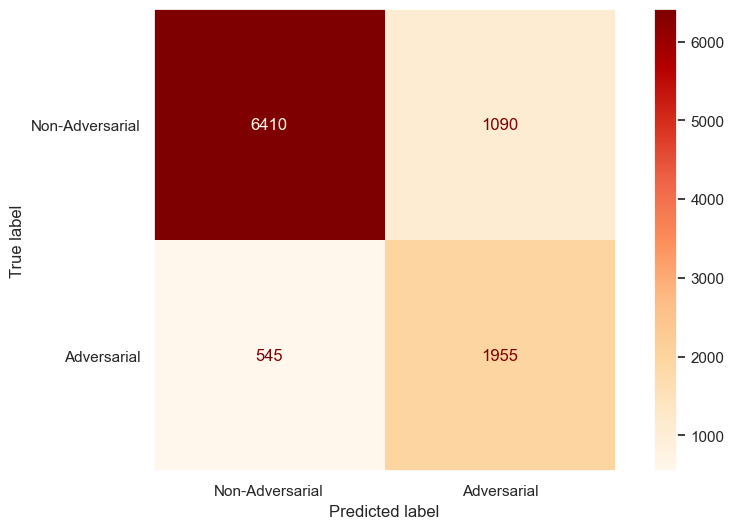

In [64]:
pgd_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'pgd',common_samples_cln,common_samples_pgd,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 3, 32, 32)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for AUTOPGD :
Class 0: 61 samples
Class 1: 59 samples
Class 2: 59 samples
Class 3: 57 samples
Class 4: 60 samples
Class 5: 58 samples
Class 6: 58 samples
Class 7: 60 samples
Class 8: 59 samples
Class 9: 61 samples
Class 10: 60 samples
Class 11: 61 samples
Class 12: 56 samples
Class 13: 60 samples
Class 14: 58 samples
Class 15: 53 samples
Class 16: 61 samples
Class 17: 35 samples
Class 18: 55 samples
Class 19: 61 samples
Class 20: 61 samples
Class 21: 50 samples
Class 22: 53 samples
Class 23: 59 samples
Class 24: 61 samples
Class 25: 56 samples
Class 26: 59 samples
Class 27: 61 samples
Class 28: 60 samples
Class 29: 61 samples
Class 30: 58 samples
Class 31: 61 samples
Class 32: 61 samples
Class 33: 59 samples
Class 34: 53 samples
Class 35: 60 samples
Class 36: 59 samples
Class 37: 61 samples
Class 38: 60 samples
Class 39: 58 samples
Class 40: 61 samples
Class 41: 59 samples
C

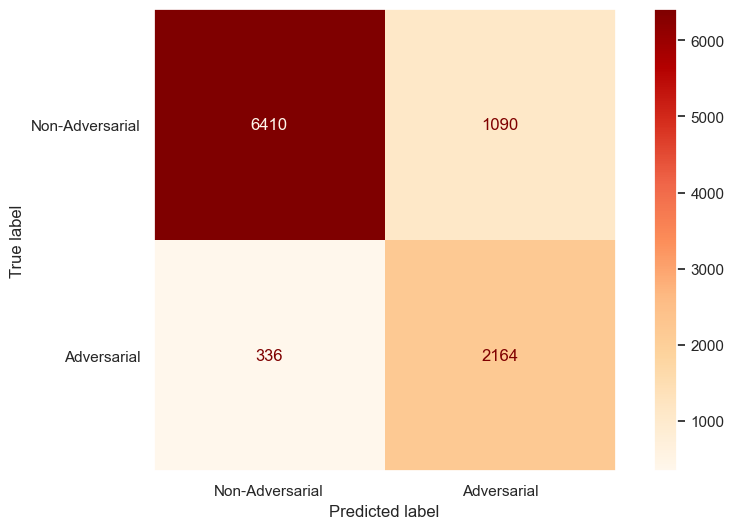

In [65]:
apgd_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'autopgd',common_samples_cln,common_samples_apgd,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 3, 32, 32)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for CW :
Class 0: 61 samples
Class 1: 59 samples
Class 2: 59 samples
Class 3: 57 samples
Class 4: 60 samples
Class 5: 58 samples
Class 6: 58 samples
Class 7: 60 samples
Class 8: 59 samples
Class 9: 61 samples
Class 10: 60 samples
Class 11: 61 samples
Class 12: 56 samples
Class 13: 60 samples
Class 14: 58 samples
Class 15: 53 samples
Class 16: 61 samples
Class 17: 35 samples
Class 18: 55 samples
Class 19: 61 samples
Class 20: 61 samples
Class 21: 50 samples
Class 22: 53 samples
Class 23: 59 samples
Class 24: 61 samples
Class 25: 56 samples
Class 26: 59 samples
Class 27: 61 samples
Class 28: 60 samples
Class 29: 61 samples
Class 30: 58 samples
Class 31: 61 samples
Class 32: 61 samples
Class 33: 59 samples
Class 34: 53 samples
Class 35: 60 samples
Class 36: 59 samples
Class 37: 61 samples
Class 38: 60 samples
Class 39: 58 samples
Class 40: 61 samples
Class 41: 59 samples
Class 

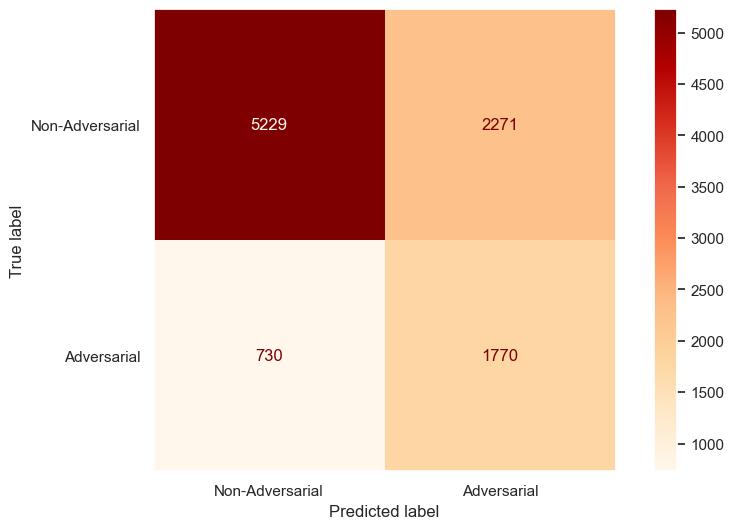

In [66]:
cw_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'cw',common_samples_cln,common_samples_cw,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 3, 32, 32)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for AP :
Class 0: 69 samples
Class 1: 59 samples
Class 2: 48 samples
Class 3: 85 samples
Class 4: 91 samples
Class 5: 66 samples
Class 6: 51 samples
Class 7: 66 samples
Class 8: 76 samples
Class 9: 86 samples
Class 10: 90 samples
Class 11: 54 samples
Class 12: 11 samples
Class 13: 45 samples
Class 14: 6 samples
Class 15: 83 samples
Class 16: 85 samples
Class 17: 52 samples
Class 18: 92 samples
Class 19: 96 samples
Class 20: 48 samples
Class 21: 52 samples
Class 22: 95 samples
Class 23: 56 samples
Class 24: 49 samples
Class 25: 43 samples
Class 26: 59 samples
Class 27: 42 samples
Class 28: 55 samples
Class 29: 52 samples
Class 30: 79 samples
Class 31: 58 samples
Class 32: 87 samples
Class 33: 29 samples
Class 34: 27 samples
Class 35: 53 samples
Class 36: 38 samples
Class 37: 25 samples
Class 38: 20 samples
Class 39: 38 samples
Class 40: 37 samples
Class 41: 58 samples
Class 4

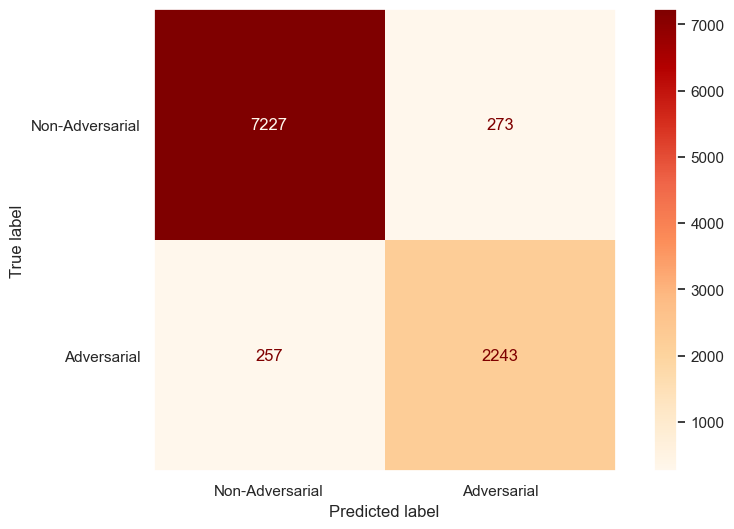

In [67]:
ap_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'ap',working_samples_ap_clean,working_samples_ap,ap_y_test,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)


# Evaluating False Positives:

## BIM Samples:

In [68]:
#Evaluate the ART classifier on benign test examples
bim_predictions = classifier.predict(bim_mpd.FP_samples)
bim_predictions=np.argmax(bim_predictions, axis=1)
bim_accuracy = np.sum(bim_predictions == bim_mpd.FP_labels) / len(bim_mpd.FP_labels)
print(f"Accuracy on the test set: {accuracy*100}%")

Accuracy on the test set: 96.04651162790697%


## PGD Samples:

In [69]:
#Evaluate the ART classifier on benign test examples
pgd_predictions = classifier.predict(pgd_mpd.FP_samples)
pgd_predictions=np.argmax(pgd_predictions, axis=1)
pgd_accuracy = np.sum(pgd_predictions == pgd_mpd.FP_labels) / len(pgd_mpd.FP_labels)
print(f"Accuracy on the test set: {pgd_accuracy*100}%")

Accuracy on the test set: 0.27522935779816515%


## APGD Samples:

In [70]:
#Evaluate the ART classifier on benign test examples
apgd_predictions = classifier.predict(apgd_mpd.FP_samples)
apgd_predictions=np.argmax(apgd_predictions, axis=1)
apgd_accuracy = np.sum(apgd_predictions == apgd_mpd.FP_labels) / len(apgd_mpd.FP_labels)
print(f"Accuracy on the test set: {apgd_accuracy*100}%")

Accuracy on the test set: 0.27522935779816515%


## CW Samples:

In [71]:
#Evaluate the ART classifier on benign test examples
cw_predictions = classifier.predict(cw_mpd.FP_samples)
cw_predictions=np.argmax(cw_predictions, axis=1)
cw_accuracy = np.sum(cw_predictions == cw_mpd.FP_labels) / len(cw_mpd.FP_labels)
print(f"Accuracy on the test set: {cw_accuracy*100}%")

Accuracy on the test set: 2.3337736679876704%


## AP Samples:

In [72]:
#Evaluate the ART classifier on benign test examples
ap_predictions = classifier.predict(ap_mpd.FP_samples)
ap_predictions=np.argmax(ap_predictions, axis=1)
ap_accuracy = np.sum(ap_predictions == ap_mpd.FP_labels) / len(ap_mpd.FP_labels)
print(f"Accuracy on the test set: {ap_accuracy*100}%")

Accuracy on the test set: 0.0%


# Plot the AE Images:

## Plot Random Images

In [73]:

def plot_random_rgb_samples(images, num_samples=100, grid_size=(10, 10)):
    fig, axes = plt.subplots(*grid_size, figsize=(10, 10))
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    for ax, idx in zip(axes.ravel(), random_indices):
        ax.imshow(np.transpose(images[idx], (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB
        ax.axis('off')
    plt.tight_layout()
    plt.show()

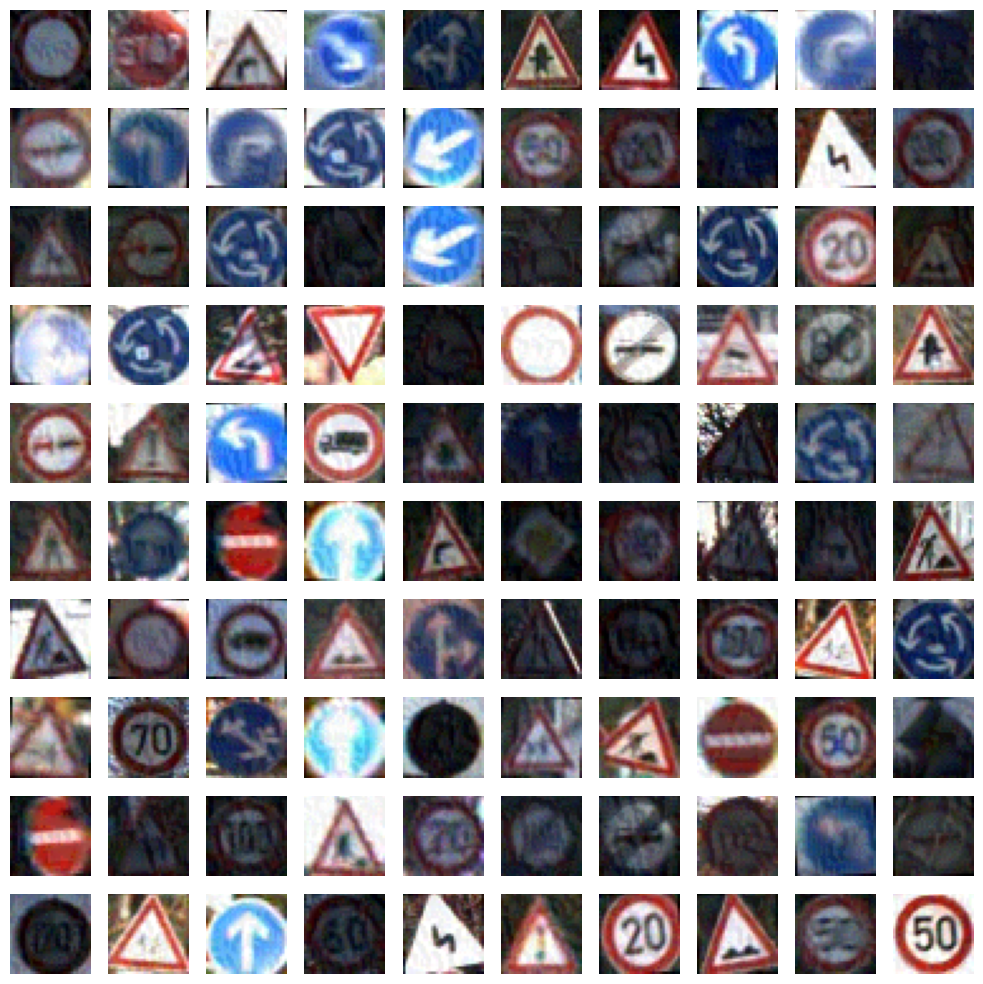

In [74]:
plot_random_rgb_samples(x_test_bim)

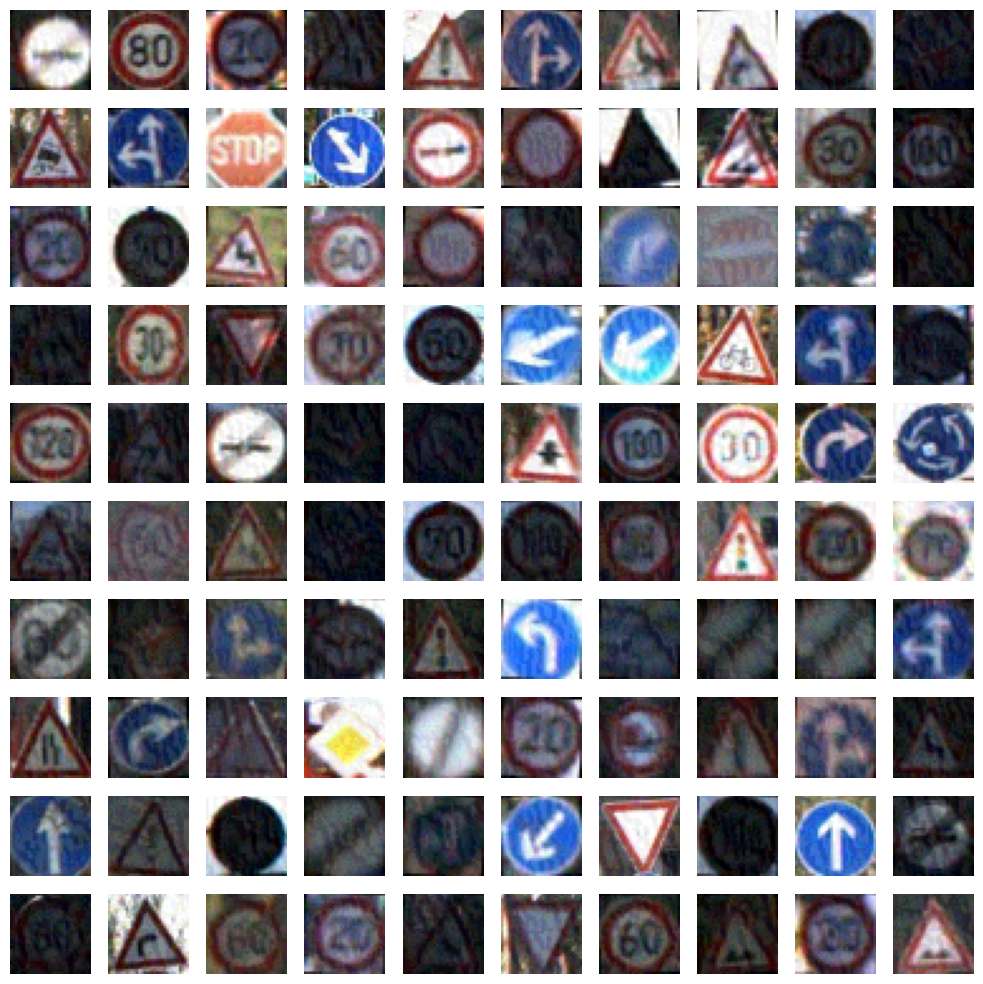

In [75]:
plot_random_rgb_samples(x_test_pgdlinf)

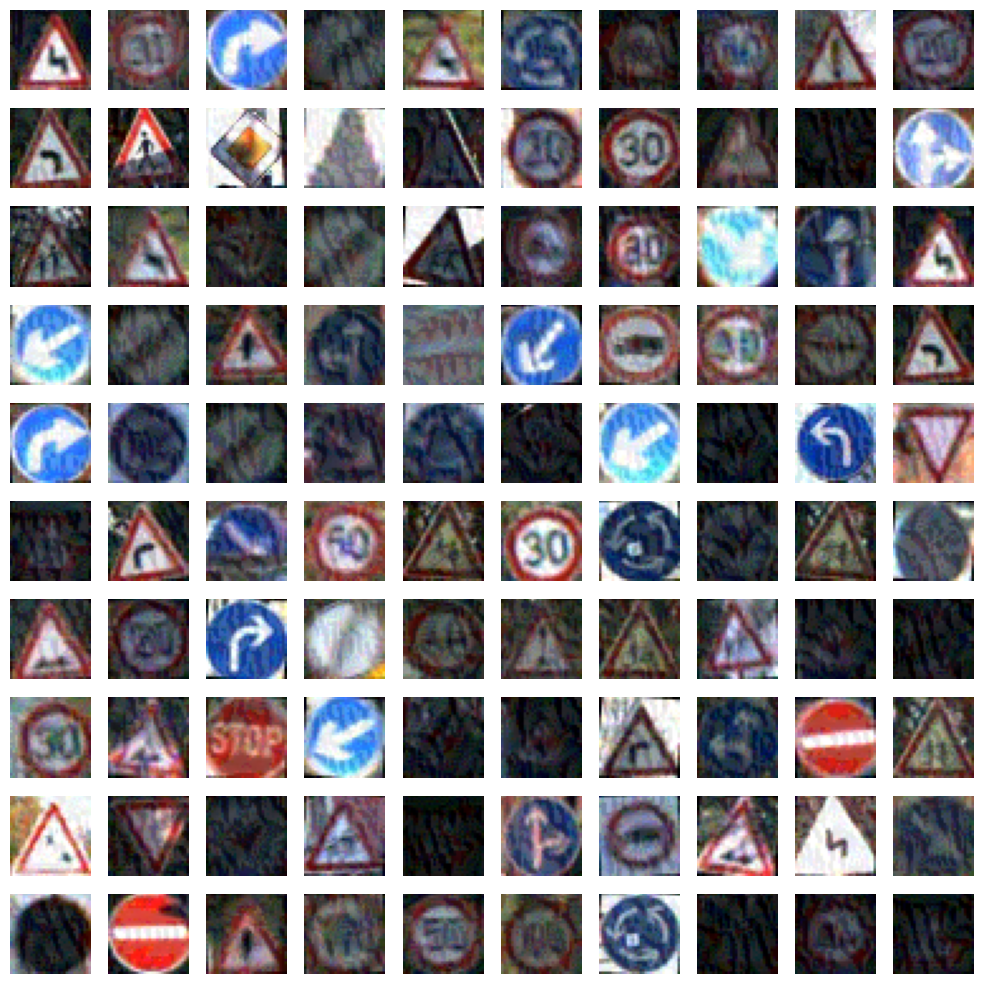

In [76]:
plot_random_rgb_samples(x_test_apgdlinf)

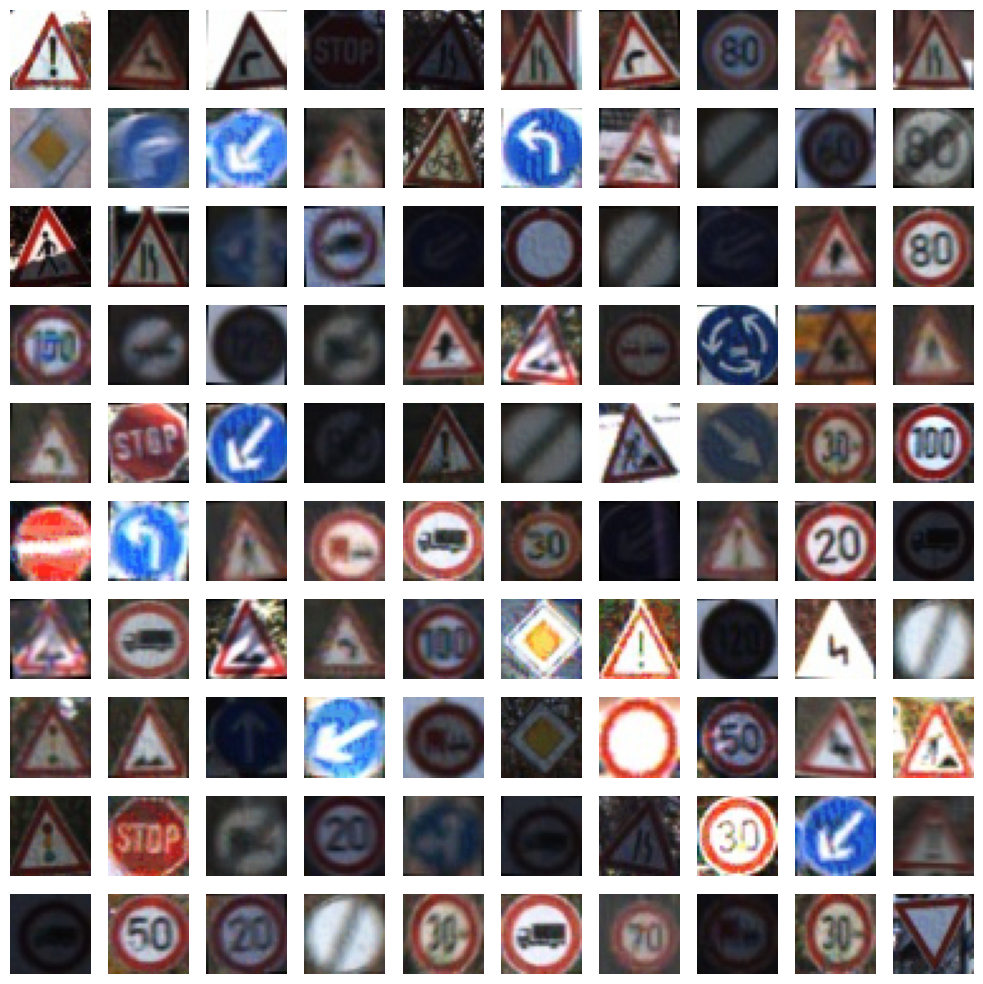

In [77]:
plot_random_rgb_samples(x_test_cwlinf)

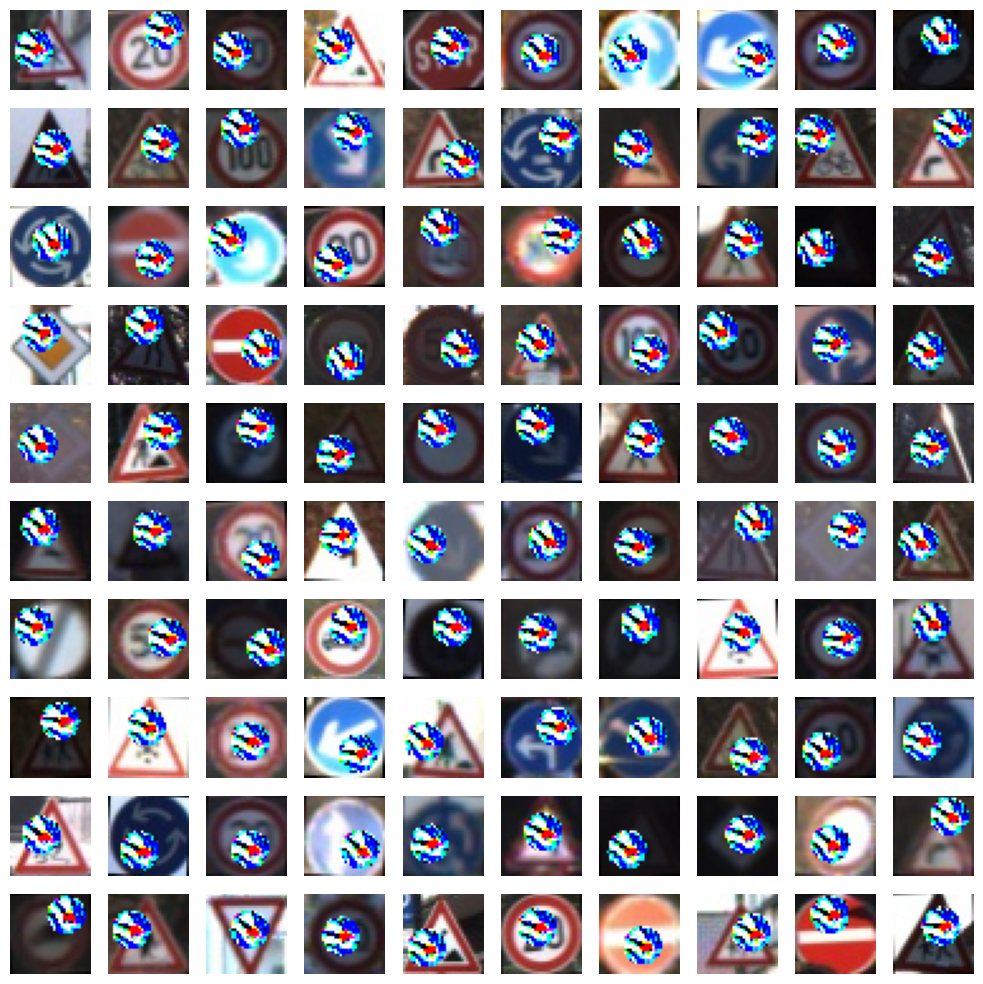

In [78]:
plot_random_rgb_samples(x_test_ap)

## Comparison of Clean Sample vs AE Sample:

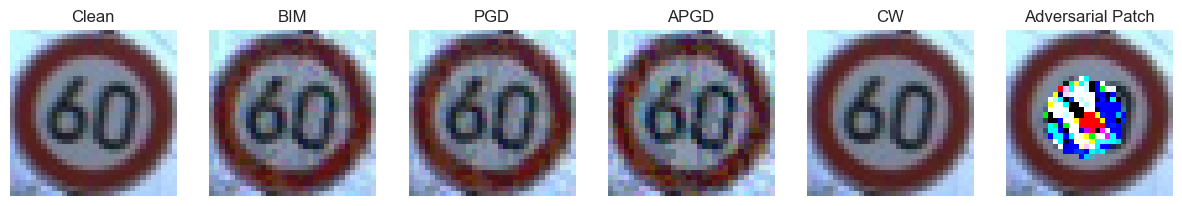

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Select one common index
index = common_indices[4]  # Change this index as needed

# Rearrange dimensions for plotting
x_test_clean_plot = np.transpose(x_test_clean[index], (1, 2, 0))
x_test_bim_plot = np.transpose(x_test_bim[index], (1, 2, 0))
x_test_pgdlinf_plot = np.transpose(x_test_pgdlinf[index], (1, 2, 0))
x_test_apgdlinf_plot = np.transpose(x_test_apgdlinf[index], (1, 2, 0))
x_test_cwlinf_plot = np.transpose(x_test_cwlinf[index], (1, 2, 0))
ap_x_test_plot = np.transpose(ap_x_test[index], (1, 2, 0))

# Plotting parameters
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Plot each image side by side
images = [x_test_clean_plot, x_test_bim_plot, x_test_pgdlinf_plot, x_test_apgdlinf_plot, x_test_cwlinf_plot, ap_x_test_plot]
titles = ['Clean', 'BIM', 'PGD', 'APGD', 'CW', 'Adversarial Patch']
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.show()
